<p style="color: red;">FYI: Use as kernel <b>MegaPlantTF</b>. Selet this in top -right corner of this notebook.</p>

<div  style="background: #fff;">
    <br>
    <div style="width: 100%; text-align: center;">
        <img src="./utils/assets/biolab.svg" style="width: 15em;"/>
    </div>
    <br>
    <hr style="color: #d74120;">
</div>


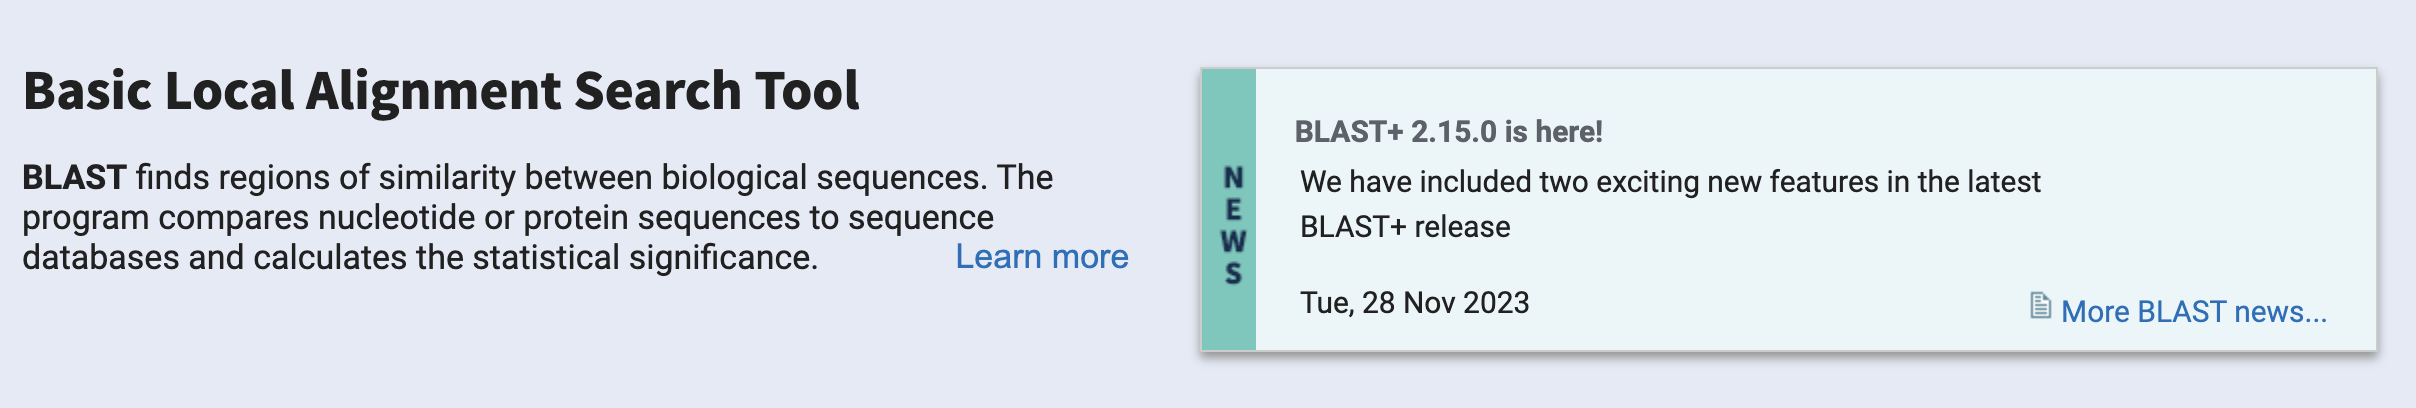

### **Hands-On 1**: Transcription factors identification in plant using BLAST (Traditional approach)

<div>
    <p style='margin-left: 1em;'>
        <b>Goal</b>: The objective of this hands-on notebook is to use BLAST to predict transcription factors by comparing sequences to a reference database. In this section, we will work with two files: one containing protein sequences with their corresponding TF families (our test file), and another representing a transcription factor database composed of sequences and TF families. This database, collected from PlantTFDB, serves as our reference.
    </p>
    <ul>
        <li>1. Our goal is to BLAST the test TF sequences against the reference database, and since we know the ground truth, we will evaluate the performance of this task.</li>
        <li>2. Then we will do the same using `MegaPlantTF` and then compare.</li>
    </ul>
</div><br>

<hr style="color: #d74120;">


### **I - Installation**

In this section we will install blast on our machine. To do so follow the installation guide in the following link based on your computer plateform.

- https://www.ncbi.nlm.nih.gov/books/NBK279690/ (guide)
- https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/ (BLAST_SOURCE)

**1. Follow those steps:**

To install BLAST, after we open the source page, we will see an output like this. We need to copy the correct link based on our operating system. Since we are on Linux, we will select the Linux version, this should be emphasized in the UI.

<img src="./utils/assets/blast1.png" style="width: 40%; border: 6px solid #ddd;"/>

Open a terminal and follow those steps:
<br>

- **Download BLAST**

In [5]:
# Let's check the installed version of BLAST. If its already installed, we can skip the installation step.

!blastp -version

blastp: 2.15.0+
 Package: blast 2.15.0, build Oct 19 2023 15:16:13


In [ ]:
!mkdir -p "$HOME/tools/BLAST" && cd "$HOME/tools/BLAST" && wget -q https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/ncbi-blast-2.17.0+-x64-linux.tar.gz

<br>


- **Extract and install**

In [3]:
!cd "$HOME/tools/BLAST" && \
tar -xzf ncbi-blast-2.17.0+-x64-linux.tar.gz && \
echo 'export PATH=$HOME/tools/BLAST/ncbi-blast-2.17.0+/bin:$PATH' >> ~/.bashrc && \
source ~/.bashrc

<br>

**2. Test that blast is installed:**

In [4]:
!blastp -version

blastp: 2.9.0+
 Package: blast 2.9.0, build Sep 30 2019 01:57:31


You should see similar ouput:
```log
biolab@user:~$ blastp -version
blastp: 2.16.0+
 Package: blast 2.16.0, build Nov 27 2024 09:40:57
```

<hr style="color: #d74120;">

### **II - Let's BLAST**


<div style="text-align:center;border: 5px solid #ddd;">
<img src="./utils/assets/blast2.png" style="height: 14em;"/>
</div>

In [28]:
import pandas as pd
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from tqdm import tqdm
import sklearn.metrics as metrics
from BLAST.utils import metric 
import sys, os, json
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
sys.path.append(root_directory)

<p style="color: ;">
    <span style='background: red; padding .9em; color: #fff; width: 2em; height: 2em;'>1. </span> &nbsp;
    Let's build our target fasta file from this csv. We will extract the sequence and the class only.
</p>

In [29]:
df = pd.read_csv('./BLAST/src/testset.csv')
df.head()

,id,sequence,length,class
0,Thhalv10001938m -- EIL,MMMFNEMGMYGKMDFFSSTSLGEIDVCPLPQAEQDHPVVEEDYTDD...,582,EIL
1,Tp1g37880 -- EIL,MGVFFSDPDSIAEDDGYTDNELDVDELEKRIWKQEMRLRRLKEHRK...,211,EIL
2,Pbr004574.1 -- EIL,MGDVGEIGPDISSDIEEDLRCDNIAEKDVSDEEIEAEDLERRMWKD...,608,EIL
3,Sme2.5_02278.1_g00005.1 -- EIL,MNNEVVEENQEFDDEEINYDDLKRRMWKDRMRMQILKGKKRDMMIE...,494,EIL
4,ONIVA11G15950.1 -- EIL,MDASKKSVMTKEEQQLSPAASPAAAVMTAEADAINEEQDKAAAATT...,466,EIL


Run this code to generate the FASTA file that we will use. Note that here, we already know the transcription factor for each sequence; however, we will assume we do not know it while performing the BLAST search, and then check the final results to evaluate BLAST’s performance on this task.

In [30]:
records = []
for i, row in df.iterrows():
    record = SeqRecord(Seq(row['sequence']), id=str(i+1), description=" | " + row['class'])
    records.append(record)

# Save to a FASTA file
output_file = "./BLAST/testset.fasta"
SeqIO.write(records, output_file, "fasta")

print(f"FASTA file saved as {output_file}. Click on the link to get a look")

FASTA file saved as ./BLAST/testset.fasta. Click on the link to get a look


<p style="color: ;">
    <span style='background: #673AB7; padding .9em; color: #fff; width: 2em; height: 2em;'>2. </span> &nbsp;
    Let's build the reference database for blast
</p>

In [31]:
ref_pah = "../data/mix_data/trainset"

gene_info_path = "../data/gene_info.json"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

records = []
for gene, info in tqdm(gene_info.items()):
    path = f"{ref_pah}/{info['file_code']}.csv"
    df_gene = pd.read_csv(path)
    df_gene = df_gene[df_gene['class'] == 1]
    for _, row in df_gene.iterrows():
        record = SeqRecord(Seq(row['sequence']), id=row['id'] + "--" + gene, description="")
        records.append(record)

# Save to a FASTA file
output_file = "./BLAST/trainset.fasta"
SeqIO.write(records, output_file, "fasta")
print(f"FASTA file saved as {output_file}")

100%|██████████| 58/58 [00:08<00:00,  7.09it/s]


FASTA file saved as ./BLAST/trainset.fasta


In [32]:
from processing.fasta import read as fasta_read
x=fasta_read("./BLAST/trainset.fasta", family=1)
x

,id,sequence,length,class
0,GSMUA_AchrUn_randomP23040_001--AP2,MNMNASDNWLDFSLSQQRCLLEAFSDAPHHHGLSLSLSLSTNAATE...,469,1
1,KHN36319.1--AP2,MNIGVPSHLHQTQPSSAAVEAVPPNFYHHTPLHNYGLYYELEGEHV...,548,1
2,678453786--AP2,MGSSQEHQSWLDFSLTNNNHLSFSSQSTCAAAAPVGGYHHRFSNLE...,315,1
3,OBART06G22270.1--AP2,MAATFYGVGSIALAMHEDDEEEGSGRVFGFAAGDLVRPAVVTQQLF...,424,1
4,MA_30905g0010--AP2,MGCHVQILVAGENNNLKAGEESSASLKSEAAAKNGSSLSQPKTKRA...,420,1
...,...,...,...,...
256274,XP_010522314.1--bZIP,MEPNDRPSHCFNLMEGNPSQNNHFNSLFLPTNTESHVQLHSVSPNT...,187,1
256275,Sp_092640_iogy.t2--bZIP,MMEDNNQIKCNNNNSSNRNRVPLMDDGELEFSNQELLSSANIGEIP...,290,1
256276,Vradi06g16770.1--bZIP,MEGVDQSNMKRNGSVFGSSSGANLRPPNRLNTAVPVSQLGVAENQK...,553,1
256277,Gorai.009G212600.2--bZIP,MGTNMNFGSNPPPSGDGGGNKPPGNNLLTRQPSIYSLTFDEFQSTM...,424,1


##### BUILD DATABASE FOR BLAST

In [33]:
!makeblastdb -in ./BLAST/trainset.fasta -dbtype prot -out ./BLAST/database/pygenomics_ref_db



Building a new DB, current time: 10/29/2025 02:16:40
New DB name:   /Users/genereux/Documents/PHD/MegaPlantTF/workshop/BLAST/database/pygenomics_ref_db
New DB title:  ./BLAST/trainset.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /Users/genereux/Documents/PHD/MegaPlantTF/workshop/BLAST/database/pygenomics_ref_db
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 256279 sequences in 5.73954 seconds.




#### RUN BLAST SEARCH TOOL

<div  style="background: #fff;">
    <br>
    <div style="width: 17em; text-align: center; background: red; padding: 1em; border-radius: 10px; color: #fff;">
        Quick BLAST?
    </div>
    <br>
    <hr style="color: #d74120;">

</div>

In [1]:
# Run this cell to get the number of threads available then use it in the blastp command for { -num_threads } parameter

!sysctl -n hw.logicalcpu

10


In [ ]:
!blastp -query ./BLAST/testset_small.fasta -db ./BLAST/database/pygenomics_ref_db -out ./BLAST/blast_result_small.txt -outfmt 6 -evalue 1e-5 -num_threads 10

<div  style="background: #fff;">
    <br>
    <div style="width: 17em; text-align: center; background: red; padding: 1em; border-radius: 10px; color: #fff;">
        BENCHMARK FOR COMPARISON
    </div>
    <br>
    <hr style="color: #d74120;">

</div>

In [ ]:
!blastp -query ./BLAST/testset.fasta -db ./BLAST/database/pygenomics_ref_db -out ./BLAST/blast_result.txt -outfmt 6 -evalue 1e-5 -num_threads 10

#### View Blast Analysis results

In [ ]:
columns = [
    "query_id", "subject_id", "perc_identity", "alignment_length",
    "mismatches", "gap_opens", "q_start", "q_end", "s_start", "s_end",
    "evalue", "bit_score"
]
blast_results = pd.read_csv("./BLAST/blast_result.txt", sep="\t", names=columns)
#blast_results.to_csv("./BLAST/blast_results.csv", index=False)

# Display the first few rows of the DataFrame
blast_results

,query_id,subject_id,perc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bit_score
0,1,676714038--EIL,89.696,592,49,6,1,581,1,591,0.000000e+00,1063.0
1,1,XP_013629559.1--EIL,84.628,592,59,10,1,581,1,571,0.000000e+00,1001.0
2,1,GSBRNA2T00066199001--EIL,83.277,592,59,10,1,581,1,563,0.000000e+00,980.0
3,1,XP_009133914.1--EIL,85.135,592,56,10,1,581,1,571,0.000000e+00,977.0
4,1,XP_009133916.1--EIL,85.135,592,56,10,1,581,1,571,0.000000e+00,977.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3006,56842,Potri.017G086200.1--NAC,48.918,231,100,6,8,229,13,234,7.040000e-65,210.0
3007,56842,Araip.FRS32--NAC,57.386,176,63,4,7,178,6,173,7.130000e-65,207.0
3008,56842,SapurV1A.2059s0010.1.p--NAC,49.782,229,94,6,8,215,11,239,7.180000e-65,210.0
3009,56842,Thhalv10027874m--NAC,51.174,213,86,4,10,215,22,223,7.260000e-65,208.0


#### Proccessing to make final inference base on threshold

In [ ]:
voting_threshold = 50
unique_query_ids = sorted(blast_results['query_id'].unique())

predictions = ["Unknown"  for _ in range(len(df))]
for query_id in tqdm(unique_query_ids, desc="Max Voting : "):
    filtered_df = blast_results[blast_results['query_id'] == query_id]
    
    # Find the row with the highest perc_identity greater than voting_threshold
    best_match = filtered_df[filtered_df['perc_identity'] > voting_threshold].sort_values(by='perc_identity', ascending=False).head(1)
    if not best_match.empty:
        subject_id = best_match.iloc[0]['subject_id']
        subject_id_part = subject_id.split('--')[-1]
        predictions[query_id-1] = (subject_id_part)

blast_prediction = pd.DataFrame({'prediction': predictions})

Max Voting : 100%|██████████| 6/6 [00:00<00:00, 1092.12it/s]


In [ ]:
with open("./BLAST/src/class_mapping.json", 'r') as json_file:
    class_mapping = json.load(json_file)
true_label = pd.read_csv("./BLAST/src/true_labels.csv")

In [ ]:
blast_prediction["predicted_label"] = blast_prediction.prediction.map(class_mapping)
blast_prediction.head()

,prediction,predicted_label
0,EIL,1
1,EIL,1
2,EIL,1
3,EIL,1
4,Unknown,0


In [ ]:
blast_prediction.shape

(64091, 2)

#### Display performance

In [ ]:
metric.show_metrics(true_label, blast_prediction.predicted_label)

In [ ]:
import importlib
importlib.reload(metric)

<module 'BLAST.utils.metric' from '/Users/genereux/Documents/PHD/MegaPlantTF/workshop/BLAST/utils/metric.py'>


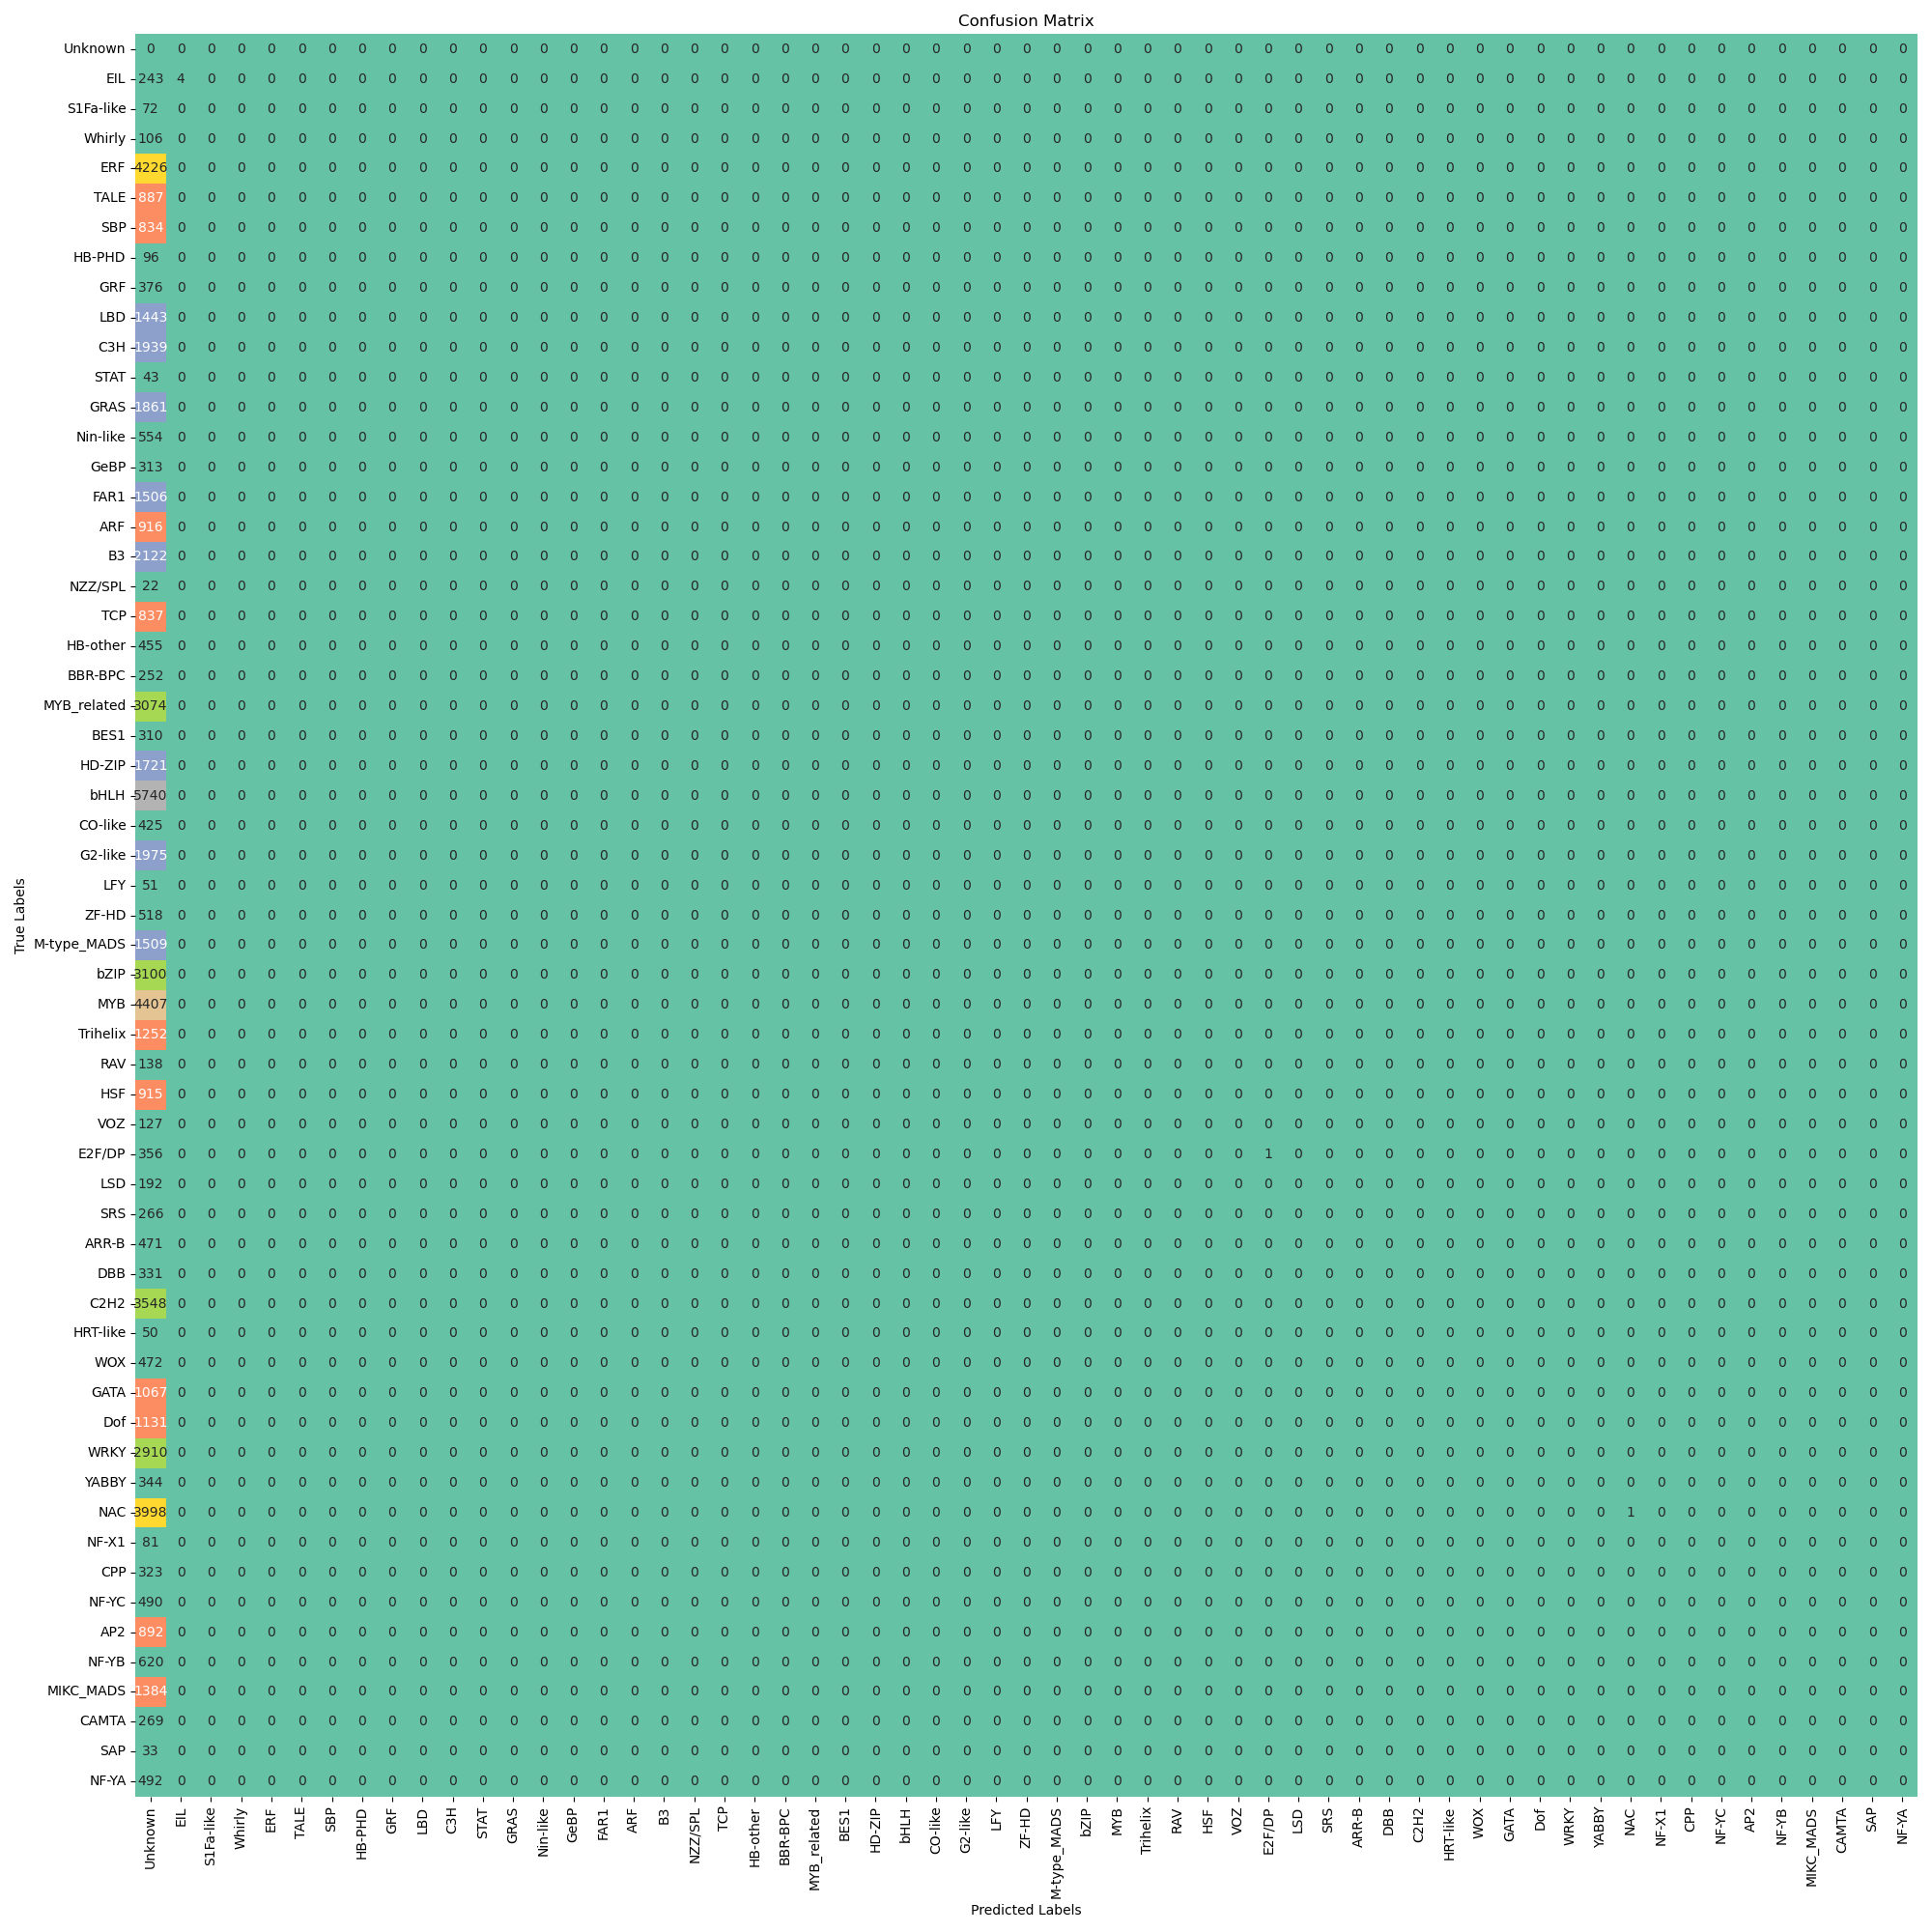

In [ ]:
metric.show_confusion(true_label, blast_prediction.predicted_label, class_mapping)